In [1]:
# version should match with torch and cuda
%%bash
pip install torch-scatter -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
pip install torch-cluster -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 39.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 40.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 17.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 12.4 MB/s eta 0:00:00


In [2]:
!pip install torch_geometric==2.2.0
!pip install torch_geometric_temporal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773275 sha256=a8b91f12c3a4bb82a50904882eb921aa80edd783a4d67403cf3673640881208b
  Stored in directory: /root/.cache/pip/wheels/c8/e4/83/5e964867e23f8a61cb8c5d5b9477617b710e96e6ebf1844562
Successfully built torch_geometric
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split

# GPU support
DEVICE = torch.device('cuda') # cuda 有GPU記得加上
shuffle=True
batch_size = 32 ##改小一

# ***Data Preprocessing***

In [38]:
df = pd.read_csv('/content/drive/MyDrive/Dissertation/DissertationData/m5-forecasting-accuracy/sales_train_evaluation.csv')
# 抓出 cat_id 為 "HOBBIES" 的數據
df_hobbies = df[df['cat_id'] == 'HOBBIES']
#df_hobbies

In [39]:
df_hobbies.shape

(5650, 1947)

In [40]:
# 2. 提取所有日期列
date_columns = [col for col in df_hobbies.columns if col.startswith('d_')]
total_days = len(date_columns)  # 確認總共有多少天

# 3. 選擇最後 365 天的列
last_365_days_columns = date_columns[-365:]

# 4. 篩選出這些天數的銷售數據
sales_data_last_365 = df_hobbies[last_365_days_columns]
print(sales_data_last_365.shape)  # 應該會輸出 (5650, 365)

(5650, 365)


In [41]:
# 5. 將 DataFrame 轉換為 PyTorch 張量
node_features_tensor = torch.tensor(sales_data_last_365.iloc[:, :-1].values, dtype=torch.float)  # 前 364 天作為特徵
labels_tensor = torch.tensor(sales_data_last_365.iloc[:, 1:].values, dtype=torch.float)  # 第 2 到 365 天作為標籤

print("Node features shape:", node_features_tensor.shape)  # 應該會輸出 (5650, 364)
print("Labels shape:", labels_tensor.shape)  # 應該會輸出 (5650, 364)

# Step 6: 計算餘弦相似度矩陣
# 先進行 L2 正規化（將每個向量的長度歸一化）
normalized_features = torch.nn.functional.normalize(node_features_tensor, p=2, dim=1)

# 計算餘弦相似度矩陣
cosine_sim_matrix = torch.matmul(normalized_features, normalized_features.t())

# 7. 設置相似度的閾值，將餘弦相似度矩陣轉換為鄰接矩陣
threshold = 0.5
adj_matrix = (cosine_sim_matrix > threshold).float()

# 8. 獲取非零元素的索引，作為邊的連接關係 (edge_index)
edge_index = adj_matrix.nonzero(as_tuple=False).t()

# 9. 根據鄰接矩陣提取對應的相似度值，作為 edge_attr
edge_attr = cosine_sim_matrix[adj_matrix.bool()]

# 現在我們有了全部的 PyTorch 張量，不需要使用 NumPy
print("Edge index shape:", edge_index.shape)
print("Edge attr shape:", edge_attr.shape)

Node features shape: torch.Size([5650, 364])
Labels shape: torch.Size([5650, 364])
Edge index shape: torch.Size([2, 308386])
Edge attr shape: torch.Size([308386])


In [80]:
# 10. 將 364 天的特徵和 364 天的標籤分割為 12 天一組
timesteps = 2
num_nodes = 5650
num_features = 1

# 將特徵數據進行 reshape，將它轉換為 [num_nodes, num_features, 364]
x = node_features_tensor.view(num_nodes, num_features, -1)

# 分割特徵為 [num_nodes, num_features, timesteps]
features_list = [x[:, :, i:i+timesteps] for i in range(0, x.size(2) - timesteps + 1, timesteps)]

# 同樣處理 targets，將它轉換為 [num_nodes, 364]
y = labels_tensor.view(num_nodes, -1)

# 分割標籤為 [num_nodes, timesteps]
targets_list = [y[:, i:i+timesteps].numpy() for i in range(0, y.size(1) - timesteps + 1, timesteps)]

# 將特徵保留為 PyTorch 張量，並將標籤轉換為 NumPy 陣列，避免 attribute error
features_list = [f.numpy() for f in features_list]

In [81]:
from torch_geometric_temporal.signal import StaticGraphTemporalSignal



# # 將 PyTorch Tensor 轉回 NumPy ndarray
# node_features_numpy = node_features_tensor.numpy()
# labels_numpy = labels_tensor.numpy()

# 創建 StaticGraphTemporalSignal 數據集
dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_attr,
    features=features_list,
    targets=targets_list
)

# 打印數據集類型
print("Dataset type: ", type(dataset))

# 計算樣本數量（序列數量）
num_samples = sum(1 for _ in dataset)
print("Number of samples / sequences: ", num_samples)

# 顯示第一個樣本的內容
first_sample = next(iter(dataset))
print("First sample:", first_sample)

Dataset type:  <class 'torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal'>
Number of samples / sequences:  182
First sample: Data(x=[5650, 1, 2], edge_index=[2, 308386], edge_attr=[308386], y=[5650, 2])


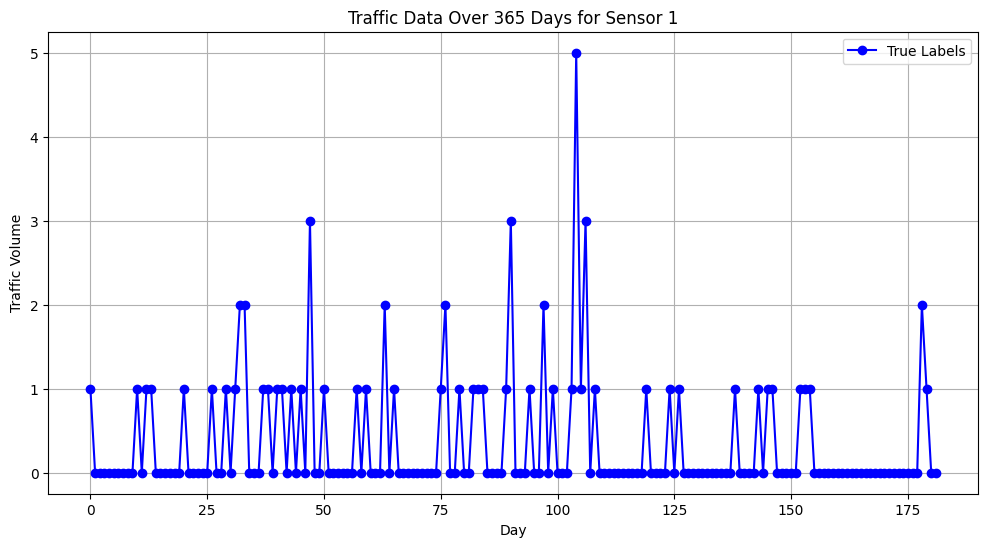

In [82]:
# # Visualize traffic over time ???
# sensor_number = 1
# days = 364
# sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:days]]
# plt.plot(sensor_labels)

import matplotlib.pyplot as plt

# 選擇你想要視覺化的傳感器編號和天數
sensor_number = 1  # 你要觀察的傳感器
days = 365  # 觀察365天的數據

# 從 dataset 中提取指定傳感器的真實標籤數據
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:days]]

# 繪製這些數據
plt.figure(figsize=(12, 6))
plt.plot(sensor_labels, marker='o', linestyle='-', color='b', label='True Labels')

plt.title(f'Traffic Data Over 365 Days for Sensor {sensor_number}')
plt.xlabel('Day')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(True)
plt.show()


In [83]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

train_count = sum(1 for _ in train_dataset)
test_count = sum(1 for _ in test_dataset)

print("Number of train buckets: ", train_count)
print("Number of test buckets: ", test_count)

Number of train buckets:  145
Number of test buckets:  37


# ***Creating DataLoaders***

In [116]:
train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
train_target = np.array(train_dataset.targets) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

print(train_input.shape)
print(train_x_tensor.shape)
print(train_target_tensor.shape)
print(train_dataset_new)
print(train_loader)

(145, 5650, 1, 2)
torch.Size([145, 5650, 1, 2])
torch.Size([145, 5650, 2])


In [117]:
test_input = np.array(test_dataset.features) # (, 207, 2, 12)
test_target = np.array(test_dataset.targets) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

print(test_input.shape)
print(test_target.shape)
print(test_x_tensor.shape)
print(test_target_tensor.shape)
print(test_dataset_new)
print(test_loader)

(37, 5650, 1, 2)
(37, 5650, 2)
torch.Size([37, 5650, 1, 2])
torch.Size([37, 5650, 2])


In [118]:
# 檢查數據集結構
print("Train features type:", type(train_dataset.features))
print("Train targets type:", type(train_dataset.targets))
print("Test features type:", type(test_dataset.features))
print("Test targets type:", type(test_dataset.targets))

# 如果它們是列表，查看第一個元素的形狀
if isinstance(train_dataset.features, list):
    print("First Train feature element shape:", train_dataset.features[0].shape)
    print("First Train target element shape:", train_dataset.targets[0].shape)

if isinstance(test_dataset.features, list):
    print("First Test feature element shape:", test_dataset.features[0].shape)
    print("First Test target element shape:", test_dataset.targets[0].shape)

# 檢查 train_loader 是否正常加載數據
print("Train loader length:", len(train_loader))
for batch in train_loader:
    print("Batch input shape:", batch[0].shape)
    print("Batch target shape:", batch[1].shape)
    break  # 只打印第一個批次，確認數據是否加載成功



Train features type: <class 'list'>
Train targets type: <class 'list'>
Test features type: <class 'list'>
Test targets type: <class 'list'>
First Train feature element shape: (5650, 1, 2)
First Train target element shape: (5650, 2)
First Test feature element shape: (5650, 1, 2)
First Test target element shape: (5650, 2)
Train loader length: 4
Batch input shape: torch.Size([32, 5650, 1, 2])
Batch target shape: torch.Size([32, 5650, 2])


# ***Model***

In [119]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h)
        h = self.linear(h)
        return h

#TemporalGNN(node_features=1, periods=12, batch_size=1)

In [120]:
# Create model and optimizers
model = TemporalGNN(node_features=1, periods=2, batch_size=batch_size).to(DEVICE) #periods 要一起改
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([2])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 1])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 1])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 1])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([2, 32])
linear.bias 	 torch.Size([2])
Net's total params: 6500
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 

# ***Graph loading***

In [121]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break;

 Current Epoch 1
LOSS: [3.9682605266571045, 3.872636079788208, 3.8581621646881104, 4.459862232208252] / LOSS AVG: 4.0397
Epoch 1 RMSE: 4.0397
 Current Epoch 2
LOSS: [4.10338830947876, 4.08214807510376, 4.154327869415283, 3.857295036315918] / LOSS AVG: 4.0493
Epoch 2 RMSE: 4.0493
 Current Epoch 3
LOSS: [4.310575008392334, 4.138171195983887, 3.818037748336792, 4.015890598297119] / LOSS AVG: 4.0707
Epoch 3 RMSE: 4.0707
 Current Epoch 4
LOSS: [4.015388488769531, 4.1856865882873535, 4.275927543640137, 3.5904383659362793] / LOSS AVG: 4.0169
Epoch 4 RMSE: 4.0169
 Current Epoch 5
LOSS: [4.075078010559082, 4.065499305725098, 4.043766975402832, 3.8862454891204834] / LOSS AVG: 4.0176
Epoch 5 RMSE: 4.0176
 Current Epoch 6
LOSS: [4.009776592254639, 4.140115737915039, 4.152873992919922, 3.8516478538513184] / LOSS AVG: 4.0386
Epoch 6 RMSE: 4.0386
 Current Epoch 7
LOSS: [4.032707214355469, 3.8252785205841064, 4.089808464050293, 4.093301296234131] / LOSS AVG: 4.0103
Epoch 7 RMSE: 4.0103
 Current Epoch 

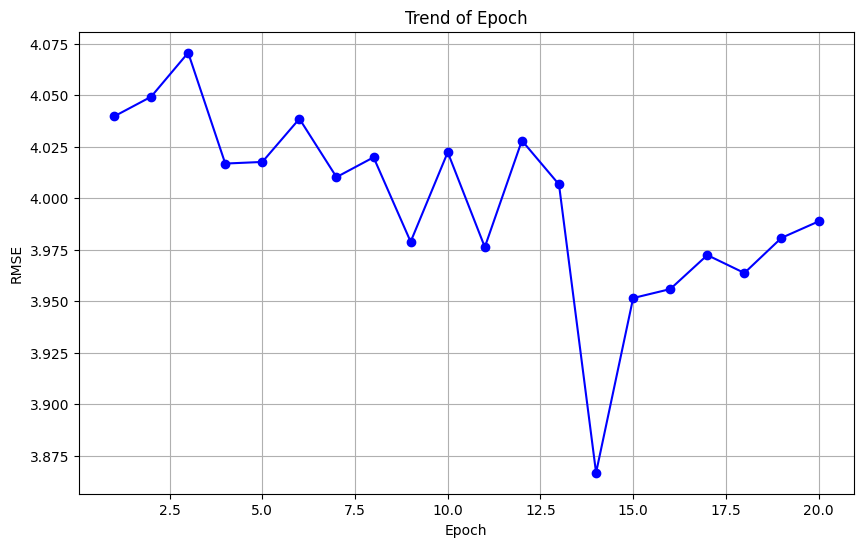

In [141]:
model.train()

#print(f"Total number of batches in train_loader: {len(train_loader)}") 看steps 要怎麼改

# 訓練設置
num_epochs = 20  # 訓練的總 epoch 數
epoch_losses = []  # 用來存儲每個 epoch 的平均損失

# 模型訓練過程
model.train()

for epoch in range(num_epochs):
    print(f" Current Epoch {epoch + 1}")
    step = 0
    loss_list = []  # 每個 epoch 開始時初始化損失列表

    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)  # 模型預測
        loss = loss_fn(y_hat, labels)  # 計算均方誤差 (MSE) 損失
        loss.backward()  # 反向傳播
        optimizer.step()  # 更新模型參數
        optimizer.zero_grad()  # 清零梯度
        step += 1
        loss_list.append(loss.item())  # 記錄當前批次的損失

        # 每4個批次打印一次當前損失和平均損失
        if step % 4 == 0:
            print("LOSS: {} / LOSS AVG: {:.4f}".format(loss_list, sum(loss_list)/len(loss_list)))

    # 計算並存儲當前 epoch 的平均損失
    epoch_loss = sum(loss_list) / len(loss_list)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch + 1} RMSE: {epoch_loss:.4f}")

# 繪製損失隨 epochs 的收斂圖
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
plt.title('Trend of Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

# ***Evaluate***

In [142]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)


print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 3.4087


# ***Visualisation***

In [143]:
sensor = 123
timestep = 1 #根據時間改動
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (32,)


<Axes: >

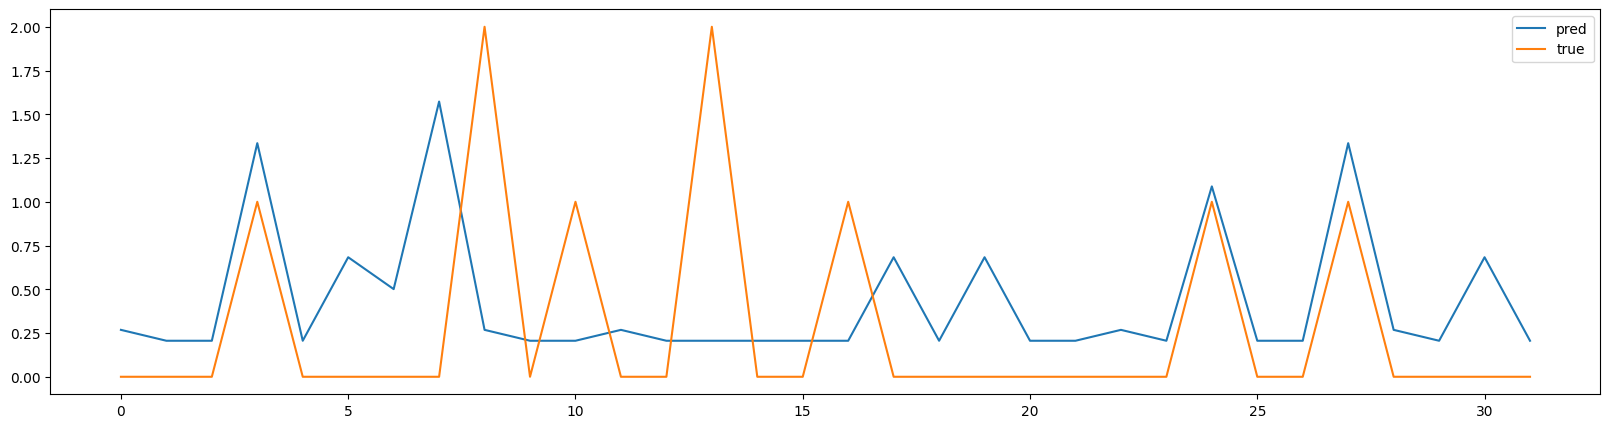

In [144]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")